In [33]:
import torch
import torch.nn as nn
import torch.nn.parallel as parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import os
import random
import argparse

from torch.utils.data import DataLoader
from torchvision import datasets as dset, transforms as T
from torchvision.utils import make_grid
from IPython.display import HTML

In [2]:
MANUAL_SEED = 101

random.seed(MANUAL_SEED)
torch.manual_seed(MANUAL_SEED)

print(f'Random seem: {MANUAL_SEED}')

Random seem: 101


In [32]:
dataroot = "C:/Users/Sachith/Desktop/dataset/celeba"    # the path to the root of the dataset folder.
workers = 2                 # the number of worker threads for loading the data with the DataLoader.
batch_size = 128            # the batch size used in training. The DCGAN paper uses a batch size of 128 (https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf).
image_size = 64             # the spatial size of the images used for training. This implementation defaults to 64x64. If another size is desired, the structures of D and G must be changed.
nc = 3                      # number of color channels in the input images. For color images this is 3.
nz = 100                    # length of latent vector.
ngf = 64                    # relates to the depth of feature maps carried through the generator.
ndf = 64                    # sets the depth of feature maps propagated through the discriminator.
num_epochs = 10             # number of training epochs to run. Training for longer will probably lead to better results but will also take much longer.
lr = 0.0002                 # learning rate for training. As described in the DCGAN paper, this number should be 0.0002
beta1 = 0.5                 # beta1 hyperparameter for Adam optimizers. As described in paper, this number should be 0.5.
ngpu = 0                    # number of GPUs available. If this is 0, code will run in CPU mode. If this number is greater than 0 it will run on that number of GPUs.

In [4]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if is_cuda and ngpu > 0 else 'cpu')
device

device(type='cpu')

### Data for training the generator and discriminator.

In [ ]:
tf = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

tf

In [21]:
dataset = dset.ImageFolder(root=dataroot, transform=tf)
dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=workers, pin_memory=is_cuda)

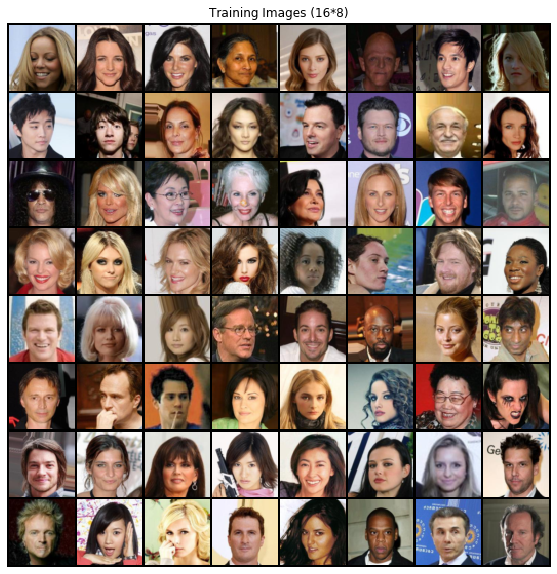

In [23]:
# Display sample batch of the data set.
batch = next(iter(dataloader))

im = make_grid(batch[0].to(device)[:64], nrow=8, normalize=True, padding=2).cpu()

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.title('Training Images (16*8)')
plt.imshow(np.transpose(im.to(device), axes=(1, 2, 0)))

### Implementation of of the networks.

#### Weight Initialization

In [31]:
def weights_init(m):
    """
    Custom weights initialization for the input tensor call on Generator and Discriminator
    networks' weights of Convolutional, ConvolutionsTranspose and BatchNormalization layers.

    Per the DCGAN paper, all the model weights shall be randomly initialized from a normal
    distribution with mean=0.0 and std=0.02.

    :param m: Network layer object to derive and update weights randomly.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, mean=0., std=.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, mean=1., std=.02)
        nn.init.constant_(m.bias.data, val=0)


#### Generator

In [38]:
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a Convolution.
            nn.ConvTranspose2d(in_channels=nz,
                               out_channels=ngf * 8,
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            # state size. (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(in_channels=ngf * 8,
                               out_channels=ngf * 4,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            # state size. (ngf * 4) x 8 x 8
            nn.ConvTranspose2d(in_channels=ngf * 4,
                               out_channels=ngf * 2,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            # state size. (ngf * 2) x 16 x 16
            nn.ConvTranspose2d(in_channels=ngf * 2,
                               out_channels=ngf,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels=ngf,
                               out_channels=nc,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


# Create the generator object.
netG = Generator().to(device)
netG

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [39]:
# Handle multi-gpu if desired.
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the 'weights_init' function to the model to randomly initialize all weights
# to mean=0.0 and std=0.02.
netG.apply(weights_init)
netG

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

#### Discriminator

In [40]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(in_channels=3,
                      out_channels=ndf,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32, 32
            nn.Conv2d(in_channels=ndf,
                      out_channels=ndf * 2,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf * 2) x 16 x 16
            nn.Conv2d(in_channels=ndf * 2,
                      out_channels=ndf * 4,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf * 4) x 8 x 8
            nn.Conv2d(in_channels=ndf * 4,
                      out_channels=ndf * 8,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf * 8) x 4 x 4
            nn.Conv2d(in_channels=ndf * 8,
                      out_channels=1,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


netD = Discriminator().to(device)
netD

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [42]:
# Handle multi-gpu if desired.
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the 'weights_init' function to model to random initialize all the weights
# to mean=0.0 and std=0.02.
netD = netD.apply(weights_init)
netD

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

#### Loss Functions and Optimizers